In [8]:
import abc
from collections import *
import random
from typing import *

import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
"""
Tic Tac Toe implementation
"""

EMPTY = 0
PLAYER = 1
OPPONENT = -1

Move = Tuple[int, int]
PlayerId = int
Reward = float

COORDINATES = [
    (1, 1),                             # Middle first
    (0, 0), (2, 0), (0, 2), (2, 2),     # Corners
    (1, 0), (0, 1), (1, 2), (2, 1)      # The rest
]

COMBINATIONS = [
    # diagonals
    {(0, 0), (1, 1), (2, 2)},
    {(2, 0), (1, 1), (0, 2)},
    # rows
    {(0, 0), (0, 1), (0, 2)},
    {(1, 0), (1, 1), (1, 2)},
    {(2, 0), (2, 1), (2, 2)},
    # cols
    {(0, 0), (1, 0), (2, 0)},
    {(0, 1), (1, 1), (2, 1)},
    {(0, 2), (1, 2), (2, 2)}
]

def next_player(player: PlayerId):
    if player == PLAYER:
        return OPPONENT
    return PLAYER

class TicTacToe:
    def __init__(self, grid):
        self.grid = grid
    
    @classmethod
    def empty(cls):
        return cls(grid=np.zeros(shape=(3, 3)))
    
    def clone(self):
        return TicTacToe(grid=self.grid.copy())
    
    def __eq__(self, other):
        return np.array_equal(self.grid, other.grid)
    
    def __hash__(self):
        return hash(self.grid.tostring())

    def available_moves(self):
        moves = []
        for move in COORDINATES:
            if self.grid[move] == EMPTY:
                moves.append(move)
        return moves
    
    def play(self, player: PlayerId, move: Move) -> Reward:
        if self.grid[move] != EMPTY:
            raise Exception("Invalid move: " + str(move))
        
        self.grid[move] = player
        winner = self.winner()
        if winner == player:
            return 1
        elif winner == next_player(player):
            return -1
        return 0
    
    def is_over(self) -> bool:
        return self.filled() or self.winner() != EMPTY
    
    def winner(self):
        for combi in COMBINATIONS:
            player_count = 0
            opponent_count = 0
            for position in combi:
                if self.grid[position] == PLAYER:
                    player_count += 1
                elif self.grid[position] == OPPONENT:
                    opponent_count += 1
            if player_count == 3:
                return PLAYER
            elif opponent_count == 3:
                return OPPONENT
        return EMPTY
    
    def filled(self):
        for pos in COORDINATES:
            if self.grid[pos] == EMPTY:
                return False
        return True

In [3]:
"""
A famous way to win a game
x x o
    x
o   o
"""

game = TicTacToe.empty()
print(game.play(PLAYER, (0, 0)))
print(game.play(OPPONENT, (2, 2)))
print(game.play(PLAYER, (0, 1)))
print(game.play(OPPONENT, (0, 2)))
print(game.play(PLAYER, (1, 2)))
print(game.play(OPPONENT, (2, 0)))
print(game.grid)
print(game.play(PLAYER, (1, 1)))
print(game.play(OPPONENT, (2, 1)))
print(game.grid)
print("winner:", game.winner())

assert TicTacToe.empty() == TicTacToe.empty()
assert hash(TicTacToe.empty()) == hash(TicTacToe.empty())

0
0
0
0
0
0
[[ 1.  1. -1.]
 [ 0.  0.  1.]
 [-1.  0. -1.]]
0
1
[[ 1.  1. -1.]
 [ 0.  1.  1.]
 [-1. -1. -1.]]
winner: -1


In [4]:
"""
An environment for an agent to play against
"""


class Agent(abc.ABC):    
    @abc.abstractmethod
    def get_action(self, game: TicTacToe) -> Move:
        pass


class TicTacToeEnv:
    def __init__(self, opponent: Agent):
        self.game: TicTacToe = TicTacToe.empty()
        self.opponent: Agent = opponent
    
    def reset(self):
        self.game = TicTacToe.empty()
        if random.choice([PLAYER, OPPONENT]) == OPPONENT:
            move = self.opponent.get_action(self.game)
            self.game.play(OPPONENT, move)
        return self.state
        
    @property
    def state(self):
        return self.game.grid
    
    def is_over(self):
        return self.game.is_over()
    
    def step(self, move: Move) -> Reward:
        self.game = self.game.clone()
        reward = self.game.play(PLAYER, move)
        if self.game.is_over():
            return reward
        
        move = self.opponent.get_action(self.game)
        reward = self.game.play(OPPONENT, move)
        return -1 * reward

In [35]:
"""
Trying out the environment with another random agent
"""


class FirstMoveAgent(Agent):
    def get_action(self, game: TicTacToe) -> Move:
        return game.available_moves()[0]


class RandomAgent(Agent):
    def __init__(self):
        pass
    
    def get_action(self, game: TicTacToe) -> Move:
        moves = game.available_moves()
        return random.choice(moves)


def play_episode(env, agent, with_log=False):
    total_reward = 0.
    env.reset()
    while not env.is_over():
        if with_log:
            print(env.game.grid)
        move = agent.get_action(env.game)
        reward = env.step(move)
        total_reward += reward
    if with_log:
        print(env.game.grid)
    return total_reward, env.state


env=TicTacToeEnv(opponent=RandomAgent())

print("Basic stats: random vs random")
stats = defaultdict(int)
for _ in range(1000):
    result, _ = play_episode(env, agent=RandomAgent())
    stats[result] += 1
print(stats)

print("Basic stats: random vs first move")
stats = defaultdict(int)
for _ in range(1000):
    result, _ = play_episode(env, agent=FirstMoveAgent())
    stats[result] += 1
print(stats)

Basic stats: random vs random
defaultdict(<class 'int'>, {1.0: 438, -1.0: 428, 0.0: 134})
Basic stats: random vs first move
defaultdict(<class 'int'>, {1.0: 718, -1.0: 225, 0.0: 57})


In [6]:
"""
All powerful agent: search throught he whole state space
"""


class AllKnowingAI(Agent):
    def __init__(self, player: PlayerId):
        self.player = player
        self.memo = {}
    
    def get_action(self, game: TicTacToe) -> Move:
        return self._best_action(game, self.player)[0]

    def _best_action(self, game: TicTacToe, player: PlayerId) -> Tuple[Move, Reward]:
        if (game, player) in self.memo:
            return self.memo[(game, player)]

        if game.is_over():
            return None, 0.

        best_move = None
        best_score = -2.0
        for move in game.available_moves():
            next_game = game.clone()
            score = next_game.play(player, move)                
            _, next_score = self._best_action(next_game, next_player(player))
            score -= 0.9 * next_score  # negate the score of opponent + discount it to prefer early victories
            if score > best_score:
                best_score = score
                best_move = move

        self.memo[(game, player)] = best_move, best_score
        return best_move, best_score
        

"""
Trying this agent
"""


env=TicTacToeEnv(opponent=RandomAgent())
result, state = play_episode(env, agent=AllKnowingAI(player=PLAYER), with_log=True)
print(result)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[ 0.  0.  0.]
 [ 0.  1.  0.]
 [-1.  0.  0.]]
[[ 1.  0.  0.]
 [-1.  1.  0.]
 [-1.  0.  0.]]
[[ 1.  0.  0.]
 [-1.  1.  0.]
 [-1.  0.  1.]]
1.0


In [31]:
"""
Tabular Q-Learning
"""


class QValues(Agent):
    def __init__(self):
        self.q_values = defaultdict(lambda: defaultdict(float))
    
    def __repr__(self):
        return repr(self.q_values)
    
    def get_action(self, game: TicTacToe) -> Move:
        best_move = None
        best_score = float('-inf')
        for move, score in self.q_values[game].items():
            if score > best_score:
                best_score = score
                best_move = move
        if best_move is None:
            best_move = random.choice(game.available_moves())
        return best_move
    
    def train(self, env: TicTacToeEnv, episodes: int,
              discount: float, learning_rate: float,
              epsilon: float, min_epsilon: float, epsilon_decrease: float):
        
        rewards = []
        targets = []
        epsilons = []
        
        for _ in trange(episodes):
            total_reward = 0.
            env.reset()
            
            while not env.is_over():
                game = env.game
                if np.random.rand(1) < epsilon:
                    move = random.choice(game.available_moves())
                else:
                    move = self.get_action(game)                        
                reward = env.step(move)
                total_reward += reward
                
                next_game = env.game
                if next_game.is_over():
                    if env.game.winner() == PLAYER:
                        epsilon = max(min_epsilon, epsilon_decrease * epsilon)
                    target_value = reward
                else:
                    next_move = self.get_action(next_game)
                    next_value = self.q_values[next_game][next_move]
                    target_value = reward + discount * next_value
                
                targets.append(target_value)
                self.q_values[game][move] += learning_rate * (target_value - self.q_values[game][move])
                # or alternatively:
                # self.q_values[game][move] = current_value * (1 - learning_rate) + learning_rate * target_value
            
            rewards.append(total_reward)
            epsilons.append(epsilon)
        
        # Reporting
        fig, ax = plt.subplots(figsize=(15, 10), nrows=3)
        ax[0].plot(rewards, label="rewards")
        ax[0].plot(pd.Series(rewards).rolling(50).mean(), label="mean rewards")
        ax[1].plot(epsilons, label="epsilon")
        ax[2].plot(targets, label="targets")
        for p in ax:
            p.legend()
        plt.show()

100%|██████████| 10000/10000 [00:08<00:00, 1234.04it/s]


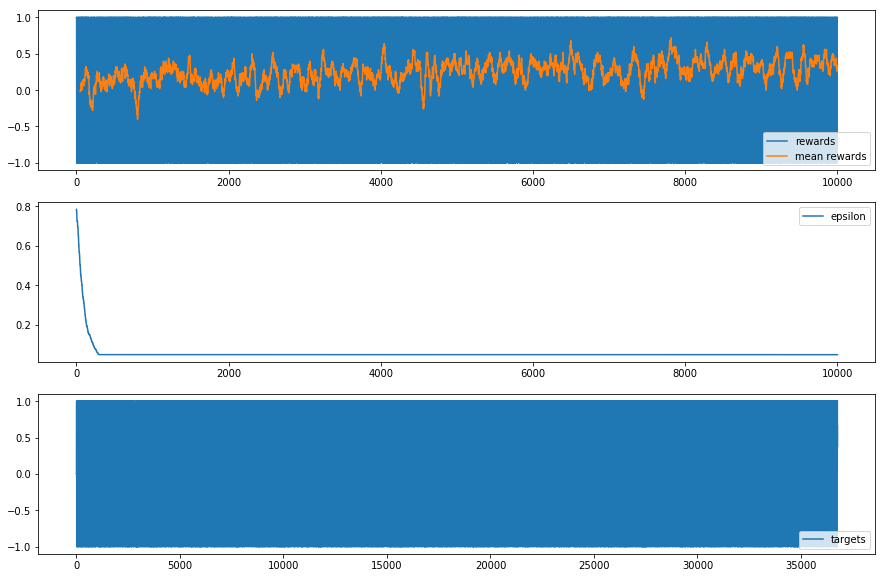

Efficiency at the end
defaultdict(<class 'int'>, {-1.0: 232, 1.0: 657, 0.0: 111})


In [36]:
"""
Training this agent against a random agent
"""


env=TicTacToeEnv(opponent=RandomAgent())
q_values = QValues()

random.seed(1)
np.random.seed(1)
q_values.train(env, episodes=10_000, discount=0.99, learning_rate=0.05, epsilon=0.8, min_epsilon=0.05, epsilon_decrease=0.98)


print("Efficiency at the end")
stats = defaultdict(int)
for _ in range(1000):
    result, _ = play_episode(env, agent=q_values)
    stats[result] += 1
print(stats)

100%|██████████| 10000/10000 [00:07<00:00, 1356.37it/s]


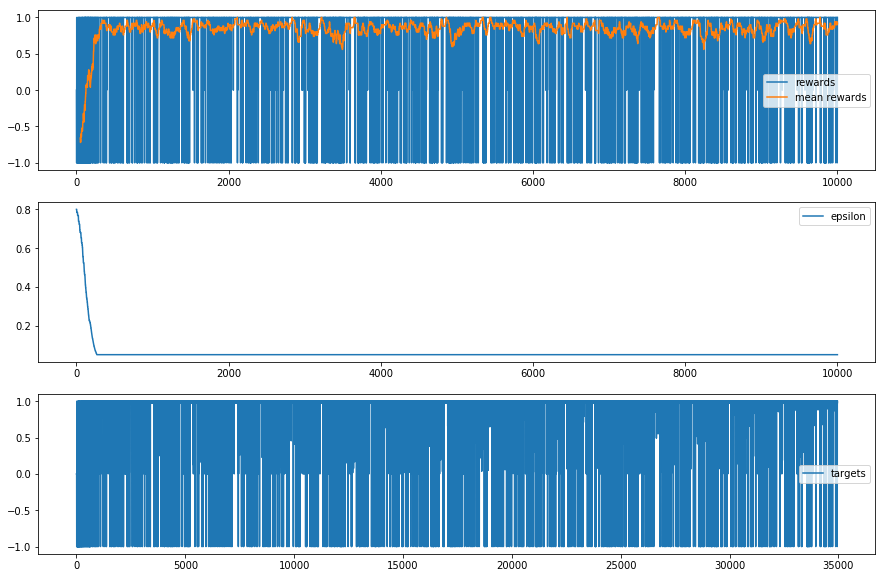

Efficiency at the end
defaultdict(<class 'int'>, {1.0: 1000})


In [38]:
"""
Training this agent against a first move agent
"""


env=TicTacToeEnv(opponent=FirstMoveAgent())
q_values = QValues()

random.seed(1)
np.random.seed(1)
q_values.train(env, episodes=10_000, discount=0.99, learning_rate=0.05, epsilon=0.8, min_epsilon=0.05, epsilon_decrease=0.98)


print("Efficiency at the end")
stats = defaultdict(int)
for _ in range(1000):
    result, _ = play_episode(env, agent=q_values)
    stats[result] += 1
print(stats)